In [2]:
import astroprov
from astropy.io.ascii import SExtractor
from astropy.stats import sigma_clipped_stats
from astropy.coordinates import SkyCoord
import astropy.coordinates as coord

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import os
from photutils import DAOStarFinder
from photutils import CircularAperture
from photutils import aperture_photometry
#import subproc

from astropy import wcs
from astropy.io import fits
import sys

from astroquery.simbad import Simbad
from astroquery.vizier import Vizier

from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.table import Table, vstack
from astropy.table import Column

import collections
import subprocess
from astropy.io import ascii
import time
from astropy.utils.data import clear_download_cache
from astroquery.gaia import Gaia
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

In [3]:
clear_download_cache()

In [4]:
tables = Gaia.load_tables(only_names=True)
for table in (tables):
    print(table.get_qualified_name())

Retrieving tables...
Parsing tables...
Done.
external.external.apassdr9
external.external.gaiadr2_geometric_distance
external.external.ravedr5_com
external.external.ravedr5_dr5
external.external.ravedr5_gra
external.external.ravedr5_on
external.external.sdssdr13_photoprimary
external.external.skymapperdr1_master
external.external.tmass_xsc
public.public.hipparcos
public.public.hipparcos_newreduction
public.public.hubble_sc
public.public.igsl_source
public.public.igsl_source_catalog_ids
public.public.tycho2
public.public.dual
tap_config.tap_config.coord_sys
tap_schema.tap_schema.columns
tap_schema.tap_schema.key_columns
tap_schema.tap_schema.keys
tap_schema.tap_schema.schemas
tap_schema.tap_schema.tables
gaiadr1.gaiadr1.aux_qso_icrf2_match
gaiadr1.gaiadr1.ext_phot_zero_point
gaiadr1.gaiadr1.allwise_best_neighbour
gaiadr1.gaiadr1.allwise_neighbourhood
gaiadr1.gaiadr1.gsc23_best_neighbour
gaiadr1.gaiadr1.gsc23_neighbourhood
gaiadr1.gaiadr1.ppmxl_best_neighbour
gaiadr1.gaiadr1.ppmxl_neighb

In [14]:
def makeDS9RegFile(sexTabList,fileNameBase,tabType):
    for tables in range(len(sexTabList)):
        if tabType == 'dao':
            xcoords = sexTabList[tables]['xcentroid']
            ycoords = sexTabList[tables]['ycentroid']
        elif tabType == 'sex':
            xcoords = sexTabList[tables]['X_IMAGE']
            ycoords = sexTabList[tables]['Y_IMAGE']
        elif tabType == 'iraf':
            xcoords = sexTabList[tables]['X_POS']
            ycoords = sexTabList[tables]['Y_POS']        
        else:
            print('tab type error')
            break
        bigString = 'global color=lightgreen\nimage\n'
        for x in range(len(xcoords)):
            bigString += 'circle({},{},5)\n'.format(xcoords[x],ycoords[x])
        fileName = fileNameBase + '.reg'
        with open(fileName,'w') as f:
            f.write(bigString)
#         print(fileName)
#         print(os.listdir('.'))

In [15]:
def load_wcs_from_file(filename,pixCoord):
    # Load the FITS hdulist using astropy.io.fits
    hdulist = fits.open(filename)

    # Parse the WCS keywords in the primary HDU
    w = wcs.WCS(hdulist[0].header)

    # Print out the "name" of the WCS, as defined in the FITS header
    #print(w.wcs.name)

    # Print out all of the settings that were parsed from the header
    w.wcs.print_contents()

    # Three pixel coordinates of interest.
    # Note we've silently assumed a NAXIS=2 image here.
    # Note also that the pixel coordinates are pairs of [X, Y], 
    # and since WCS built from FITS header automatically has
    # origin set to 1, [0, 0] is actually not inside the image.
    pixcrd = np.array(pixCoord, dtype=np.float_)

    # Convert pixel coordinates to world coordinates
    # The second argument is "origin" -- in this case we're declaring we
    # have 1-based (Fortran-like) coordinates.
    world = w.wcs_pix2world(pixcrd, 1)
    #print(world)
    return(world)

In [121]:
def queryObjectRegion(outputTable,searchRadius=15*u.arcsecond):
    imageCoords = []
    r = searchRadius
    
#     if inCat == 'dao':
#         xlabel = 'xcentroid'
#         ylabel = 'ycentroid'
#         label = 'id'
        
#     if inCat == 'sex':
#         xlabel = 'X_IMAGE'
#         ylabel = 'Y_IMAGE'
#         label = 'NUMBER'
        
    xlabel = 'RA'
    ylabel = 'DEC'
    label = 'NUMBER'
    
    flux = outputTable['FLUX_BEST']   
    ra = outputTable['RA']
    dec = outputTable['DEC']
    tableLength = len(outputTable)
    xcoord = outputTable['X_IMAGE']
    ycoord = outputTable['Y_IMAGE']
    imageCoords = [[x,y] for x,y in zip(xcoord,ycoord)]
    imageNames = outputTable['DIFF_NAME']
    customSimbad = Simbad()
    customSimbad.add_votable_fields('ra(d)','dec(d)','otype')
    customSimbad.remove_votable_fields('coordinates')
            
    result_table = Table([['-'],[0],[0],['-'],[0],[0],[0],['-'],[0]],names=('MAIN_ID','RA_d','DEC_d','OTYPE','xcentroid','ycentroid','flux','IMAGE','index'),dtype=('object','float64','float64','object','float64','float64','float64','object','object'))


    for x in range(len(imageCoords)):
        try:
            c = SkyCoord(ra[x],dec[x],frame='icrs',unit='deg')
            rt = customSimbad.query_region(c,radius=r)
            rowlist = []
            
            for y in range(len(rt[0])):
                rowlist.append(rt[0][y])
            rowlist.append(imageCoords[x][0])
            rowlist.append(imageCoords[x][1])
            rowlist.append(flux[x])
            rowlist.append(imageNames[x])
            rowlist.append(x)
            result_table.add_row(rowlist)

        except:
            #print('searchfailed')
            result_table.add_row(['N/A',ra[x],dec[x],'Object Not Found',[imageCoords[x][0]],[imageCoords[x][1]],flux[x],imageNames[x],x])

    
    return result_table

In [29]:
def queryObjectRegionVizier(outputTable,searchRadius=5*u.arcsecond):
    imageCoords = []
    r = searchRadius
        
    xlabel = 'RA'
    ylabel = 'DEC'
    label = 'NUMBER'
    
    flux = outputTable['FLUX_BEST']   
    ra = outputTable['RA']
    dec = outputTable['DEC']
    tableLength = len(outputTable)
    xcoord = outputTable['X_IMAGE']
    ycoord = outputTable['Y_IMAGE']
    imageCoords = [[x,y] for x,y in zip(xcoord,ycoord)]
    imageNames = outputTable['DIFF_NAME']
    possibleObjs = ['Class','objectClass','otype','objecttype','objType','SpType']
    vs = Vizier(columns=['_RAJ2000', '_DEJ2000','VMAG','Class','objectClass','otype','objecttype','objType','SpType'])
    result_table = Table([[0],[0],['-'],['-'],[0],[0],[0],['-'],[0]],names=('RA_d','DEC_d','Vmag','CLASS','xcentroid','ycentroid','flux','IMAGE','index'),dtype=('float64','float64','object','object','float64','float64','float64','object','int'))

    #tables = []
    
    for x in range(len(imageCoords)):
        #print(ra,dec)
        c = SkyCoord(ra[x],dec[x],frame='icrs',unit='deg')
        rt = vs.query_region(c,width=searchRadius)
        if len(rt) != 0:
            #print(len(rt))
            for tabRange in range(len(rt)):
                #print(rt[0])
                
                rtra = rt[tabRange]['_RAJ2000'][0]
                rtdec = rt[tabRange]['_DEJ2000'][0]
                try:
                    vmag = rt[tabRange]['_V'][0]
                except:
                    vmag = 'N\A'
                row = [rtra,rtdec,vmag]
                otypeBinary = 0 
                for obs in possibleObjs:
                    try:
                        rtobs = rt[tabRange][obs][0]
                        otypeBinary = 1
                        name = pos
                    except:
                        pass
                if otypeBinary == 0:
                    row.append('No Object Type')
                else:
                    row.append(rtobs)
                rowlist = row
#                 tables.append(rt)
                rowlist.append(imageCoords[x][0])
                rowlist.append(imageCoords[x][1])
                rowlist.append(flux[x])
                rowlist.append(imageNames[x])
                rowlist.append(x)
                result_table.add_row(rowlist)

        else:
            #print('searchfailed')
            result_table.add_row([ra[x],dec[x],'0','Object Not Found',[imageCoords[x][0]],[imageCoords[x][1]],flux[x],imageNames[x],0])

    
    return result_table

In [102]:
def findSeparation(ra1,dec1,ra2,dec2):
    c1 = SkyCoord(ra=ra1*u.degree,dec=dec1*u.degree)
    c2 = SkyCoord(ra=ra2*u.degree,dec=dec2*u.degree)
    sep = c1.separation(c2)
    separc = sep.arcsec
    return separc

In [114]:
def getTabValues(Tab,index,tabType,origra,origdec):
    rowlist = 'none'
    if tabType == 'simbad':
        otypename = 'OTYPE'
        source = 'SIMBAD'
    if tabType == 'vizier':
        source = 'VIZIER'
        otypename = 'CLASS'
    Tab = Tab[1:]
    df = Tab.to_pandas()
    df2 = df[df[otypename] != 'Object Not Found']
    df3 = df2[df2['index'] == index]
    if len(df3) != 0:
        ra = df3['RA_d'].tolist()
        dec = df3['DEC_d'].tolist()
        otype = df3[otypename].tolist()
        separations = [round(findSeparation(ra1,dec1,origra,origdec),3) for ra1,dec1 in zip(ra,dec)]
        rowlist = [[index,source,0,0,x,y,0,0,'magfilter',sep,z] for x,y,z,sep in zip(ra,dec,otype,separations)]
    return rowlist

In [112]:
def bigTable(origTab,simbadTab,vizierTab):
    origra = origTab['RA'].tolist()
    origdec = origTab['DEC'].tolist()
    origImage = origTab['IMAGE_NAME'].tolist()
    xim = origTab['X_IMAGE']
    yim = origTab['Y_IMAGE']
    origmag = origTab['MAG_BEST']
    magDiff = origTab['magDiff']
    searchTables = [simbadTab,vizierTab]
    searchTabNames = ['simbad','vizier']
    #result_table = Table([[0],[0],['-'],['-'],[0],[0],[0],['-'],[0]],names=('RA_d','DEC_d','Vmag','CLASS','xcentroid','ycentroid','flux','IMAGE','index'),dtype=('float64','float64','object','object','float64','float64','float64','object','int'))
    for x in range(len(origra)):
        if x == 0:
            rowlist = [[x],[origImage[x]],[xim[x]],[yim[x]],[origra[x]],[origdec[x]],[origmag[x]],[magDiff[x]],['-'],[0],['-']]
            namelist = ['OBJECT INDEX','SOURCE','X_IMAGE','Y_IMAGE','RA_d','DEC_d','MAG_DIFF','MAG','MAG_FILTER','SEPARATION','OTYPE']
            types = ['int','object','float64','float64','float64','float64','float64','float64','object','float64','object']
            result_table = Table(rowlist,names=namelist,dtype=types)
            for tab in range(len(searchTables)):
                rowlist = getTabValues(searchTables[tab],x,searchTabNames[tab],origra[x],origdec[x])
                if rowlist != 'none':
                    for row in rowlist:
                        result_table.add_row(row,mask=[True,False,True,True,False,False,True,True,True,False,False])
        else:
            rowlist = [x,origImage[x],xim[x],yim[x],origra[x],origdec[x],origmag[x],magDiff[x],'-',0,'-']
            result_table.add_row(rowlist,mask=[False,False,False,False,False,False,False,False,True,True,True])
            for tab in range(len(searchTables)):
                rowlist = getTabValues(searchTables[tab],x,searchTabNames[tab],origra[x],origdec[x])
                if rowlist != 'none':
                    for row in rowlist:
                        result_table.add_row(row,mask=[True,False,True,True,False,False,True,True,True,False,False])
    return result_table

In [109]:
a = 0.187523348765
print(round(a,3))

0.188


In [117]:
bigTable(otherGaiaTab[0:5],simbadSearch,vizierSearch)

INFO: Upgrading Table to masked Table. Use Table.filled() to convert to unmasked table. [astropy.table.table]


OBJECT INDEX,SOURCE,X_IMAGE,Y_IMAGE,RA_d,DEC_d,MAG_DIFF,MAG,MAG_FILTER,SEPARATION,OTYPE
int64,object,float64,float64,float64,float64,float64,float64,object,float64,object
0,kplr2009114174833_ffi-cal.fits[58],429.9972,24.7407,291.9081476036849,47.058497168533194,15.7586,-4.733674110651155,-,0.0,-
1,kplr2009115131122_ffi-cal.fits[16],618.8993,260.8472,282.2997286819453,48.51511298543987,16.3204,-3.0588167843178122,--,--,--
2,kplr2009115131122_ffi-cal.fits[18],127.6044,916.9813,286.17639521590405,44.443401074095455,16.3832,-4.250811469125403,--,--,--
3,kplr2009260000800_ffi-cal.fits[76],1039.0616,993.9548,282.51787304188844,47.587614950317615,16.3583,-4.9381187120948,--,--,--
4,kplr2009351005245_ffi-cal.fits[75],341.8187,226.6804,286.16801092086166,37.67179113909842,16.055,-3.5398002117672567,--,--,--
--,SIMBAD,--,--,286.1674519875751,37.6725297870107,--,--,--,3.1,RGB*
--,VIZIER,--,--,286.167489,37.672489,--,--,--,2.919,0
--,VIZIER,--,--,286.16749,37.67249,--,--,--,2.921,0
--,VIZIER,--,--,286.167299965,37.672483792,--,--,--,3.213,No Object Type


In [101]:
ras = simbadSearch['RA_d']
decs = simbadSearch['DEC_d']
c1 = SkyCoord(ra=ras[1]*u.degree,dec=decs[1]*u.degree)
c2 = SkyCoord(ra=ras[2]*u.degree,dec=decs[2]*u.degree)
sep = c1.separation(c2)
print(sep.arcsec)

23807.7316867


In [71]:
simbadSearch

MAIN_ID,RA_d,DEC_d,OTYPE,xcentroid,ycentroid,flux,IMAGE,index
object,float64,float64,object,float64,float64,float64,object,object
-,0.0,0.0,-,0.0,0.0,0.0,-,0
N/A,291.9081476036849,47.058497168533194,Object Not Found,429.9972,24.7407,4972.103,diff_imNo11_channel18_ccd58.fits,0
N/A,282.2997286819453,48.51511298543987,Object Not Found,618.8993,260.8472,2963.834,diff_imNo49_channel12_ccd16.fits,1
N/A,286.17639521590405,44.443401074095455,Object Not Found,127.6044,916.9813,2797.135,diff_imNo49_channel26_ccd18.fits,2
N/A,282.51787304188844,47.587614950317615,Object Not Found,1039.0616,993.9548,2862.116,diff_imNo14_channel12_ccd76.fits,3
2MASS J19044019+3740211,286.1674519875751,37.6725297870107,RGB*,341.8187,226.6804,3784.545,diff_imNo28_channel71_ccd75.fits,4
KIC 6267115,284.7196699802004,41.6760072017319,Star,947.2881,593.7286,3451.97,diff_imNo25_channel49_ccd49.fits,5
2MASS J19393539+4900241,294.897456592791,49.0067104408479,RGB*,645.012,273.612,3651.136,diff_imNo31_channel13_ccd13.fits,6
KIC 10256300,283.1588365335496,47.3937710691911,Star,847.0221,792.5739,4922.818,diff_imNo31_channel9_ccd9.fits,7


In [19]:
otherGaiaTab = ascii.read('/home/mj1e16/outTablesImproved/fullMatches.csv')

In [221]:
vizierSearch = queryObjectRegionVizier(otherGaiaTab,searchRadius=2*u.arcsecond)


57
  _RAJ2000     _DEJ2000    _V 
    deg          deg          
------------ ------------ ----
283.15903900  47.39384800 VMAG
  _RAJ2000     _DEJ2000    _V 
    deg          deg          
------------ ------------ ----
283.15903900  47.39384800 VMAG
  _RAJ2000     _DEJ2000    _V 
    deg          deg          
------------ ------------ ----
283.15903900  47.39384800 VMAG
  _RAJ2000     _DEJ2000    _V 
    deg          deg          
------------ ------------ ----
283.15903900  47.39384800 VMAG
  _RAJ2000     _DEJ2000    _V 
    deg          deg          
------------ ------------ ----
283.15903900  47.39384800 VMAG
  _RAJ2000     _DEJ2000    _V 
    deg          deg          
------------ ------------ ----
283.15903900  47.39384800 VMAG
  _RAJ2000     _DEJ2000    _V 
    deg          deg          
------------ ------------ ----
283.15903900  47.39384800 VMAG
  _RAJ2000     _DEJ2000    _V 
    deg          deg          
------------ ------------ ----
283.15903900  47.39384800 VMAG
  _RA

In [26]:
simbadSearch = queryObjectRegion(otherGaiaTab,searchRadius=5*u.arcsecond)

In [30]:
for x in range(1,6):
    simbadSearch = queryObjectRegion(otherGaiaTab,searchRadius=x*u.arcsecond)
    ascii.write(simbadSearch,'/home/mj1e16/outTablesImproved/simbad{}.csv'.format(x),format='csv',fast_writer=False)
    vizierSearch = queryObjectRegionVizier(otherGaiaTab,searchRadius=x*u.arcsecond)
    ascii.write(vizierSearch,'/home/mj1e16/outTablesImproved/vizier{}.csv'.format(x),format='csv',fast_writer=False)

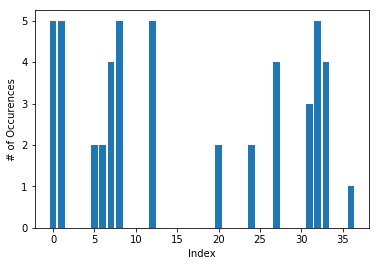

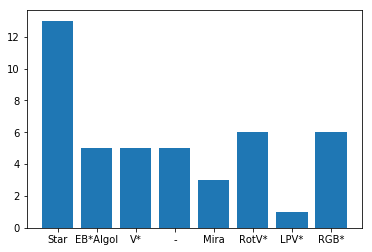

In [52]:
indexes = simbadSearch['index'].tolist()
set(indexes)
foundSum = []
objectTypes =[]
for x in range(1,6):
    tab = ascii.read('/home/mj1e16/outTablesImproved/simbad{}.csv'.format(x))
    df = tab.to_pandas()
    #objectTypes.extend(df)
    df2 = df[df['OTYPE'] != 'Object Not Found']
    objectTypes.extend(df2['OTYPE'])
    indexFound = df2['index'].tolist()
    if x == 1:
        foundorNot = [1 if y in indexFound else 0 for y in indexes]
    else:
        fon = [1 if y in indexFound else 0 for y in indexes]
        foundorNot = [y + z for y,z in zip(fon,foundorNot)]
index = range(len(foundorNot))
discreteOtypes = set(objectTypes)
num = []
for x in discreteOtypes:
    num.append(objectTypes.count(x))
plt.bar(index,foundorNot)
plt.xlabel('Index')
plt.ylabel('# of Occurences')
plt.show()

disoindex = range(len(num))
plt.bar(disoindex,num)
plt.xticks(disoindex, discreteOtypes)
plt.show()

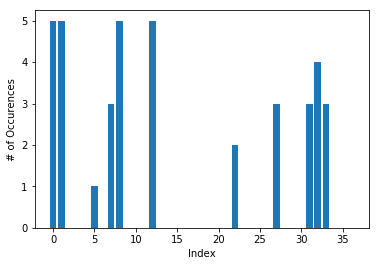

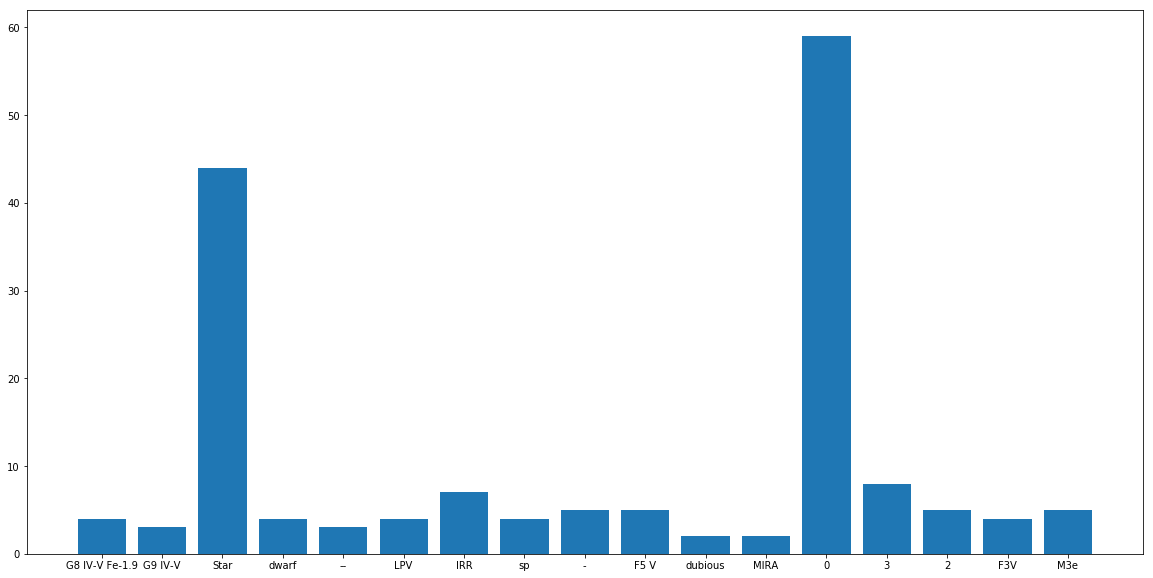

In [56]:
indexes = simbadSearch['index'].tolist()
set(indexes)
foundSum = []
objectTypes =[]

for x in range(1,6):
    tab = ascii.read('/home/mj1e16/outTablesImproved/vizier{}.csv'.format(x))
    df = tab.to_pandas()
    df2 = df[df['CLASS'] != 'Object Not Found']
    df3 = df2[df2['CLASS'] != 'No Object Type']
    objectTypes.extend(df3['CLASS'])
    indexFound = df3['index'].tolist()
    if x == 1:
        foundorNot = [1 if y in indexFound else 0 for y in indexes]
    else:
        fon = [1 if y in indexFound else 0 for y in indexes]
        foundorNot = [y + z for y,z in zip(fon,foundorNot)]
        
#    df3 = df2[df2['CLASS'] != 'No Object Type']
index = range(len(foundorNot))
discreteOtypes = set(objectTypes)
num = []
for x in discreteOtypes:
    num.append(objectTypes.count(x))
    
plt.bar(index,foundorNot)
plt.xlabel('Index')
plt.ylabel('# of Occurences')
plt.show()

disoindex = range(len(num))
plt.figure(figsize=[20,10])
plt.bar(disoindex,num)
plt.xticks(disoindex, discreteOtypes)
plt.show()

In [42]:
num = 1
simbadTab = ascii.read('/home/mj1e16/outTablesImproved/simbad{}.csv'.format(num))
df = simbadTab.to_pandas()
df2 = df[df['OTYPE'] != 'Object Not Found']
df2

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [46]:
num = 2
vizTab = ascii.read('/home/mj1e16/outTablesImproved/vizier{}.csv'.format(num))
df = vizTab.to_pandas()
df2 = df[df['CLASS'] != 'Object Not Found']
df3 = df2[df2['CLASS'] != 'No Object Type']
df3

,RA_d,DEC_d,Vmag,CLASS,xcentroid,ycentroid,flux,IMAGE,index
0,0.000000,0.000000,-,-,0.0000,0.0000,0.000,-,0
9,283.158910,47.393770,VMAG,0,847.0221,792.5739,4922.818,diff_imNo31_channel9_ccd9.fits,7
11,283.158907,47.393826,VMAG,3,847.0221,792.5739,4922.818,diff_imNo31_channel9_ccd9.fits,7
14,283.158908,47.393827,VMAG,0,847.0221,792.5739,4922.818,diff_imNo31_channel9_ccd9.fits,7
37,283.159042,47.393847,VMAG,Star,847.0221,792.5739,4922.818,diff_imNo31_channel9_ccd9.fits,7
38,283.159042,47.393847,VMAG,Star,847.0221,792.5739,4922.818,diff_imNo31_channel9_ccd9.fits,7
39,283.159042,47.393847,VMAG,Star,847.0221,792.5739,4922.818,diff_imNo31_channel9_ccd9.fits,7
40,283.159042,47.393847,VMAG,Star,847.0221,792.5739,4922.818,diff_imNo31_channel9_ccd9.fits,7
56,283.159027,47.393848,VMAG,F3V,847.0221,792.5739,4922.818,diff_imNo31_channel9_ccd9.fits,7
58,283.158780,47.393791,VMAG,F5 V,847.0221,792.5739,4922.818,diff_imNo31_channel9_ccd9.fits,7


In [47]:
a = [1,2,3,3,3,3]
B = set(a)
print(B,a)

(set([1, 2, 3]), [1, 2, 3, 3, 3, 3])


In [35]:
c

[0, 1, 1]

In [21]:
ascii.write(simbadSearch,'/home/mj1e16/outTablesImproved/simbad2.csv',format='csv',fast_writer=False)

In [232]:
ascii.write(vizierSearch,'/home/mj1e16/outTablesImproved/vizier.csv',format='csv',fast_writer=False)

In [22]:
simbad2 = ascii.read('/home/mj1e16/outTablesImproved/simbad2.csv')

In [27]:
df = simbadSearch.to_pandas()
df2 = df[df['OTYPE'] != 'Object Not Found']
df2

,MAIN_ID,RA_d,DEC_d,OTYPE,xcentroid,ycentroid,flux,IMAGE,index
0,-,0.000000,0.000000,-,0.0000,0.0000,0.000,-,0
5,2MASS J19044019+3740211,286.167452,37.672530,RGB*,341.8187,226.6804,3784.545,diff_imNo28_channel71_ccd75.fits,4
6,KIC 6267115,284.719670,41.676007,Star,947.2881,593.7286,3451.970,diff_imNo25_channel49_ccd49.fits,5
7,2MASS J19393539+4900241,294.897457,49.006710,RGB*,645.0120,273.6120,3651.136,diff_imNo31_channel13_ccd13.fits,6
8,KIC 10256300,283.158837,47.393771,Star,847.0221,792.5739,4922.818,diff_imNo31_channel9_ccd9.fits,7
12,KOI-6167,283.066275,43.743557,EB*Algol,851.0325,318.8774,4745.730,diff_imNo40_channel30_ccd54.fits,11
24,KIC 11124157,284.165028,48.762276,Star,46.3901,778.0478,2068.993,diff_imNo7_channel7_ccd35.fits,23
27,KIC 11014223,282.702775,48.599169,RotV*,382.8395,347.2336,2633.672,diff_imNo33_channel12_ccd12.fits,26
31,V* WY Lyr,283.432181,40.304176,Mira,828.0455,122.7324,46189.730,diff_imNo13_channel51_ccd79.fits,30
32,ASAS J195004+4336.4,297.517376,43.605445,V*,731.5602,243.9939,14502.800,diff_imNo32_channel60_ccd28.fits,31


In [24]:
df = simbad2.to_pandas()
df2 = df[df['OTYPE'] != 'Object Not Found']
df2


,MAIN_ID,RA_d,DEC_d,OTYPE,xcentroid,ycentroid,flux,IMAGE,index
0,-,0.000000,0.000000,-,0.0000,0.0000,0.000,-,0
7,2MASS J19393539+4900241,294.897457,49.006710,RGB*,645.0120,273.6120,3651.136,diff_imNo31_channel13_ccd13.fits,6
8,KIC 10256300,283.158837,47.393771,Star,847.0221,792.5739,4922.818,diff_imNo31_channel9_ccd9.fits,7
12,KOI-6167,283.066275,43.743557,EB*Algol,851.0325,318.8774,4745.730,diff_imNo40_channel30_ccd54.fits,11
27,KIC 11014223,282.702775,48.599169,RotV*,382.8395,347.2336,2633.672,diff_imNo33_channel12_ccd12.fits,26
32,ASAS J195004+4336.4,297.517376,43.605445,V*,731.5602,243.9939,14502.800,diff_imNo32_channel60_ccd28.fits,31
33,KIC 11284185,284.144097,49.035986,Star,192.0007,575.1609,2626.705,diff_imNo42_channel7_ccd79.fits,32


In [234]:
simbadSearch

MAIN_ID,RA_d,DEC_d,OTYPE,xcentroid,ycentroid,flux,IMAGE,index
object,float64,float64,object,float64,float64,float64,object,object
-,0.0,0.0,-,0.0,0.0,0.0,-,0
N/A,291.9081476036849,47.058497168533194,Object Not Found,429.9972,24.7407,4972.103,diff_imNo11_channel18_ccd58.fits,0
N/A,282.2997286819453,48.51511298543987,Object Not Found,618.8993,260.8472,2963.834,diff_imNo49_channel12_ccd16.fits,1
N/A,286.17639521590405,44.443401074095455,Object Not Found,127.6044,916.9813,2797.135,diff_imNo49_channel26_ccd18.fits,2
N/A,282.51787304188844,47.587614950317615,Object Not Found,1039.0616,993.9548,2862.116,diff_imNo14_channel12_ccd76.fits,3
2MASS J19044019+3740211,286.1674519875751,37.6725297870107,RGB*,341.8187,226.6804,3784.545,diff_imNo28_channel71_ccd75.fits,4
KIC 6267115,284.7196699802004,41.6760072017319,Star,947.2881,593.7286,3451.97,diff_imNo25_channel49_ccd49.fits,5
2MASS J19393539+4900241,294.897456592791,49.0067104408479,RGB*,645.012,273.612,3651.136,diff_imNo31_channel13_ccd13.fits,6
KIC 10256300,283.1588365335496,47.3937710691911,Star,847.0221,792.5739,4922.818,diff_imNo31_channel9_ccd9.fits,7


In [28]:
vizierSearch = queryObjectRegionVizier(otherGaiaTab,searchRadius=1*u.arcsecond)
df = vizierSearch.to_pandas()
df2 = df[df['CLASS'] != 'Object Not Found']
df3 = df2[df2['CLASS'] != 'No Object Type']
df3

44
  _RAJ2000    _DEJ2000   _V  Class
    deg         deg               
----------- ----------- ---- -----
283.1589100  47.3937700 VMAG     0
  _RAJ2000    _DEJ2000   _V  Class
    deg         deg               
----------- ----------- ---- -----
283.1589100  47.3937700 VMAG     0
  _RAJ2000    _DEJ2000   _V  Class
    deg         deg               
----------- ----------- ---- -----
283.1589100  47.3937700 VMAG     0
  _RAJ2000    _DEJ2000   _V  Class
    deg         deg               
----------- ----------- ---- -----
283.1589100  47.3937700 VMAG     0
  _RAJ2000    _DEJ2000   _V  Class
    deg         deg               
----------- ----------- ---- -----
283.1589100  47.3937700 VMAG     0
  _RAJ2000    _DEJ2000   _V  Class
    deg         deg               
----------- ----------- ---- -----
283.1589100  47.3937700 VMAG     0
  _RAJ2000    _DEJ2000   _V  Class
    deg         deg               
----------- ----------- ---- -----
283.1589100  47.3937700 VMAG     0
  _RAJ2000    _DE

KeyboardInterrupt: 

In [177]:
vizierSearch = queryObjectRegionVizier(otherGaiaTab,searchRadius=5*u.arcsecond)
df = vizierSearch.to_pandas()
df2 = df[df['CLASS'] != 'Object Not Found']
df2

  _RAJ2000     _DEJ2000   Class  _V 
    deg          deg                
------------ ------------ ----- ----
286.16748900  37.67248900     0 VMAG
  _RAJ2000    _DEJ2000  Class  _V 
    deg         deg               
----------- ----------- ----- ----
294.8974900  49.0067900     0 VMAG
  _RAJ2000    _DEJ2000  Class  _V 
    deg         deg               
----------- ----------- ----- ----
283.1589100  47.3937700     0 VMAG
  _RAJ2000    _DEJ2000  Class  _V 
    deg         deg               
----------- ----------- ----- ----
283.0662600  43.7436300     0 VMAG
283.0661900  43.7436600     0 VMAG
  _RAJ2000     _DEJ2000   Class  _V 
    deg          deg                
------------ ------------ ----- ----
281.39102500  47.86203800     3 VMAG
281.39086300  47.86210500     3 VMAG
  _RAJ2000    _DEJ2000  Class  _V 
    deg         deg               
----------- ----------- ----- ----
282.7028400  48.5993200     0 VMAG
  _RAJ2000    _DEJ2000  Class  _V 
    deg         deg               
--

,RA_d,DEC_d,CLASS,Vmag,xcentroid,ycentroid,flux,IMAGE
0,0.000000,0.000000,-,0,0.0000,0.0000,0.000,-
5,286.167489,37.672489,0,VMAG,341.8187,226.6804,3784.545,diff_imNo28_channel71_ccd75.fits
7,294.897490,49.006790,0,VMAG,645.0120,273.6120,3651.136,diff_imNo31_channel13_ccd13.fits
8,283.158910,47.393770,0,VMAG,847.0221,792.5739,4922.818,diff_imNo31_channel9_ccd9.fits
12,283.066260,43.743630,0,VMAG,851.0325,318.8774,4745.730,diff_imNo40_channel30_ccd54.fits
22,281.391025,47.862038,3,VMAG,807.2390,369.9034,1363.519,diff_imNo48_channel11_ccd15.fits
27,282.702840,48.599320,0,VMAG,382.8395,347.2336,2633.672,diff_imNo33_channel12_ccd12.fits
31,283.432200,40.304170,0,VMAG,828.0455,122.7324,46189.730,diff_imNo13_channel51_ccd79.fits
32,297.517357,43.605428,0,VMAG,731.5602,243.9939,14502.800,diff_imNo32_channel60_ccd28.fits
33,284.144030,49.035960,0,VMAG,192.0007,575.1609,2626.705,diff_imNo42_channel7_ccd79.fits


In [178]:
vizierSearch

RA_d,DEC_d,CLASS,Vmag,xcentroid,ycentroid,flux,IMAGE
float64,float64,object,object,float64,float64,float64,object
0.0,0.0,-,0,0.0,0.0,0.0,-
291.9081476036849,47.058497168533194,Object Not Found,[0],429.9972,24.7407,4972.103,diff_imNo11_channel18_ccd58.fits
282.2997286819453,48.51511298543987,Object Not Found,[0],618.8993,260.8472,2963.834,diff_imNo49_channel12_ccd16.fits
286.17639521590405,44.443401074095455,Object Not Found,[0],127.6044,916.9813,2797.135,diff_imNo49_channel26_ccd18.fits
282.51787304188844,47.587614950317615,Object Not Found,[0],1039.0616,993.9548,2862.116,diff_imNo14_channel12_ccd76.fits
286.167489,37.672489,0,VMAG,341.8187,226.6804,3784.545,diff_imNo28_channel71_ccd75.fits
284.7198297858132,41.675149597439834,Object Not Found,[0],947.2881,593.7286,3451.97,diff_imNo25_channel49_ccd49.fits
294.89749,49.00679,0,VMAG,645.012,273.612,3651.136,diff_imNo31_channel13_ccd13.fits
283.15891,47.39377,0,VMAG,847.0221,792.5739,4922.818,diff_imNo31_channel9_ccd9.fits


In [7]:
tabTot =  ascii.read('/home/mj1e16/outTablesImproved/sexdiffOutTest.csv')

In [8]:
tabTot = ascii.read('/home/mj1e16/outTablesImproved/firsthalf.csv')

In [61]:
# upload_resource = '/home/mj1e16/outTables15/matchplus3Magdiff.csv'
# j = Gaia.launch_job(query="select * from tap_upload.table_test", upload_resource=upload_resource, \
# upload_table_name="table_test", verbose=True)
# r = j.get_results()
# r.pprint()

In [15]:
def gaiaSearch(table):
    RA = table['RA']
    DEC = table['DEC']
    width = u.Quantity(5., u.arcsecond)
    height = u.Quantity(5., u.arcsecond)
    #coord = [str(RA[0])+','+str(DEC[0])]
    t0 = time.time()
    for x in range(len(RA)):
        coord = SkyCoord(ra=RA[x], dec=DEC[x], unit=(u.degree, u.degree), frame='icrs')
        if x ==0:
            result_table = Gaia.query_object_async(coordinate=coord, width=width, height=height)
        else:
            newtab = Gaia.query_object_async(coordinate=coord, width=width, height=height)
            if len(newtab) != 0:
                result_table.add_row(newtab[0])
    print(time.time() - t0)
    return result_table

In [18]:
def colourMag(table):
    parallax = table['parallax']
    distance = [1./(x/1000.) for x in parallax]
    paraError = table['parallax_error']
    colour = table['bp_rp']
    gmag = table['phot_g_mean_mag']
    extinction = table['a_g_val']


    colourGood = [x for x,y,z in zip(colour,paraError,parallax) if y<0.25*z]
    distanceGood = [x for x,y,z in zip(distance,paraError,parallax) if y<0.25*z]
    gmagGood = [x for x,y,z in zip(gmag,paraError,parallax) if y<0.25*z]
    exctinctionGood = [x for x,y,z in zip(extinction,paraError,parallax) if y<0.25*z]

    absoluteMag = [mag - (5*(np.log10(dist)))  + 5 for mag,dist,ext in zip(gmagGood,distanceGood,exctinctionGood)]
    return {'absMag':absoluteMag,'colour':colourGood}

In [113]:
# RA = tabTot['RA']
# DEC = tabTot['DEC']
# width = u.Quantity(5., u.arcsecond)
# height = u.Quantity(5., u.arcsecond)
# #coord = [str(RA[0])+','+str(DEC[0])]
# t0 = time.time()
# for x in range(10000): #len(RA)):
#     coord = SkyCoord(ra=RA[x], dec=DEC[x], unit=(u.degree, u.degree), frame='icrs')
#     if x ==0:
#         result_table = Gaia.query_object_async(coordinate=coord, width=width, height=height)
#     else:
#         newtab = Gaia.query_object_async(coordinate=coord, width=width, height=height)
#         if len(newtab) != 0:
#             result_table.add_row(newtab[0])
# print(time.time() - t0)

In [12]:
#ascii.write(result_table,'/home/mj1e16/outTablesImproved/gaiaObjects.csv',format='csv',fast_writer=False)
ascii.write(result_table,'/home/mj1e16/outTablesImproved/gaiaTab.csv',format='csv',fast_writer=False)

In [13]:
otherGaiaTab = ascii.read('/home/mj1e16/outTablesImproved/fullMatches.csv')

In [115]:
simbadSearch = queryObjectRegion(otherGaiaTab,searchRadius=5*u.arcsecond)

In [180]:
oclass = vizierSearch['CLASS']
vmag = vizierSearch['Vmag']
simbadSearch['Vmag'] = vmag
simbadSearch['Class'] = oclass
simbadSearch

MAIN_ID,RA_d,DEC_d,OTYPE,xcentroid,ycentroid,flux,IMAGE,Vmag,Class
object,float64,float64,object,float64,float64,float64,object,object,object
-,0.0,0.0,-,0.0,0.0,0.0,-,0,-
N/A,291.9081476036849,47.058497168533194,Object Not Found,429.9972,24.7407,4972.103,diff_imNo11_channel18_ccd58.fits,[0],Object Not Found
N/A,282.2997286819453,48.51511298543987,Object Not Found,618.8993,260.8472,2963.834,diff_imNo49_channel12_ccd16.fits,[0],Object Not Found
N/A,286.17639521590405,44.443401074095455,Object Not Found,127.6044,916.9813,2797.135,diff_imNo49_channel26_ccd18.fits,[0],Object Not Found
N/A,282.51787304188844,47.587614950317615,Object Not Found,1039.0616,993.9548,2862.116,diff_imNo14_channel12_ccd76.fits,[0],Object Not Found
2MASS J19044019+3740211,286.1674519875751,37.6725297870107,RGB*,341.8187,226.6804,3784.545,diff_imNo28_channel71_ccd75.fits,VMAG,0
KIC 6267115,284.7196699802004,41.6760072017319,Star,947.2881,593.7286,3451.97,diff_imNo25_channel49_ccd49.fits,[0],Object Not Found
2MASS J19393539+4900241,294.897456592791,49.0067104408479,RGB*,645.012,273.612,3651.136,diff_imNo31_channel13_ccd13.fits,VMAG,0
KIC 10256300,283.1588365335496,47.3937710691911,Star,847.0221,792.5739,4922.818,diff_imNo31_channel9_ccd9.fits,VMAG,0


In [182]:
ascii.write(simbadSearch,'/home/mj1e16/outTablesImproved/otypes.csv',format='csv',fast_writer=False)

In [154]:
vizierSearch = queryObjectRegionVizier(otherGaiaTab,searchRadius=5*u.arcsecond)
df = vizierSearch.to_pandas()
df2 = df[df['CLASS'] != 'Object Not Found']
df2

Empty TableList
Empty TableList
Empty TableList
Empty TableList
TableList with 2 tables:
	'0:I/271/out' with 4 column(s) and 1 row(s) 
	'1:I/305/out' with 4 column(s) and 1 row(s) 
  _RAJ2000     _DEJ2000   Class  _V 
    deg          deg                
------------ ------------ ----- ----
286.16748900  37.67248900     0 VMAG
Empty TableList
TableList with 4 tables:
	'0:I/254/out' with 4 column(s) and 1 row(s) 
	'1:I/255/out' with 4 column(s) and 1 row(s) 
	'2:I/271/out' with 4 column(s) and 1 row(s) 
	'3:I/305/out' with 4 column(s) and 1 row(s) 
  _RAJ2000    _DEJ2000  Class  _V 
    deg         deg               
----------- ----------- ----- ----
294.8974900  49.0067900     0 VMAG
TableList with 4 tables:
	'0:I/254/out' with 4 column(s) and 1 row(s) 
	'1:I/255/out' with 4 column(s) and 1 row(s) 
	'2:I/271/out' with 4 column(s) and 2 row(s) 
	'3:I/305/out' with 4 column(s) and 2 row(s) 
  _RAJ2000    _DEJ2000  Class  _V 
    deg         deg               
----------- ----------- ---

In [157]:
df = vizierSearch.to_pandas()
df2 = df[df['CLASS'] != 'Object Not Found']
df2

,MAIN_ID,RA_d,DEC_d,CLASS,Vmag,xcentroid,ycentroid,flux,IMAGE
0,-,0.0,0.0,-,0.0,0.0,0.0,0.0,-


In [128]:
df = vizierSearch.to_pandas()
df2 = df[df['CLASS'] != 'Object Not Found']
smallTab = Table.from_pandas(df2)
smallTab

MAIN_ID,RA_d,DEC_d,CLASS,Vmag,xcentroid,ycentroid,flux,IMAGE
str1,float64,float64,str1,float64,float64,float64,float64,str1
-,0.0,0.0,-,0.0,0.0,0.0,0.0,-


In [117]:
df = simbadSearch.to_pandas()
df2 = df[df['OTYPE'] != 'Object Not Found']
smallTab = Table.from_pandas(df2)
smallTab

MAIN_ID,RA_d,DEC_d,OTYPE,xcentroid,ycentroid,flux,IMAGE
str23,float64,float64,str8,float64,float64,float64,str32
-,0.0,0.0,-,0.0,0.0,0.0,-
2MASS J19044019+3740211,286.1674519875751,37.6725297870107,RGB*,341.8187,226.6804,3784.545,diff_imNo28_channel71_ccd75.fits
KIC 6267115,284.7196699802004,41.6760072017319,Star,947.2881,593.7286,3451.97,diff_imNo25_channel49_ccd49.fits
2MASS J19393539+4900241,294.897456592791,49.0067104408479,RGB*,645.012,273.612,3651.136,diff_imNo31_channel13_ccd13.fits
KIC 10256300,283.1588365335496,47.3937710691911,Star,847.0221,792.5739,4922.818,diff_imNo31_channel9_ccd9.fits
KOI-6167,283.0662745616069,43.7435568227975,EB*Algol,851.0325,318.8774,4745.73,diff_imNo40_channel30_ccd54.fits


In [17]:
newGaiaTab = gaiaSearch(otherGaiaTab)

Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
16.1608419418


In [22]:
# if using a table previously made
#result_table = ascii.read('/home/mj1e16/outTablesImproved/gaiaTab.csv')

In [23]:
refmagandcolour = colourMag(result_table)

In [24]:
magandcolour =colourMag(newGaiaTab)

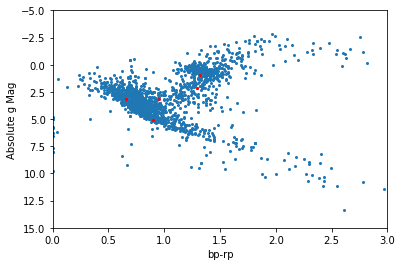

In [25]:
plt.plot(refmagandcolour['colour'],refmagandcolour['absMag'],'o',markersize=2)
plt.plot(magandcolour['colour'],magandcolour['absMag'],'ro',markersize=2)
plt.ylim([-5,15])
plt.xlim([0,3])
plt.gca().invert_yaxis()
plt.ylabel('Absolute g Mag')
plt.xlabel('bp-rp')
plt.show()

In [27]:
gaiaMag = result_table['phot_g_mean_mag']
keplerMag = tabTot['MAG_BEST'][0:10000]

In [37]:
def testfindMatches(tabTot,matchTab,arcsec=2.5*u.arcsec,low=0,high=10000):
    tabMini = tabTot[low:high]
    matches = 'not matched'
    ra1 = matchTab['ra']
    dec1 = matchTab['dec']
    idx = []
    ra2 = tabMini['RA']
    dec2 = tabMini['DEC']    
    c = SkyCoord(ra=ra1, dec=dec1,unit=(u.hourangle,u.deg),frame='fk5')
    catalog = SkyCoord(ra=ra2*u.degree, dec=dec2*u.degree)
    idx, d2d, d3d = c.match_to_catalog_sky(catalog)
    sep_constraint = d2d < max_sep
#     print(len(matches))
#     print(matches)
    tabMini.remove_rows(idx)
    objectsFound = number1[sep_constraint]
    origdf = bigdf[bigdf['NUMBER'].isin(objectsFound)]
    return tabMini

In [99]:
def findMatchesNoCondition(tab,match,df,bigdf,max_sep = 2.5 * u.arcsec):
    
    number1 = match['index']
    ra1 = match['ra']
    dec1 = match['dec']

    number2 = tab['index'] # difference image
    ra2 = tab['RA']
    dec2 = tab['DEC']    
    
    cat1 = SkyCoord(ra=ra1*u.degree, dec=dec1*u.degree)
    cat2 = SkyCoord(ra=ra2*u.degree, dec=dec2*u.degree)
    
    idx, d2d, d3d = cat2.match_to_catalog_sky(cat1)
    sep_constraint = d2d < max_sep
    objectsFound = number2[sep_constraint]
    matchdf = df[df['index'].isin(objectsFound)]
    matchTab = Table.from_pandas(matchdf)

    idx, d2d, d3d = cat1.match_to_catalog_sky(cat2)
    sep_constraint = d2d < max_sep
    #istrue = [x for x in sep_constraint if x == True]
    objectsFound = number1[sep_constraint]
    origdf = bigdf[bigdf['index'].isin(objectsFound)]
    origTab = Table.from_pandas(origdf)
    
    return [matchTab,origTab]

In [93]:
indexes = [i for i in range(10000)]
rtindexes = [i for i in range(len(result_table))]
tabMini = tabTot[0:10000]
tabMini['index'] = indexes
result_table['index'] = rtindexes
df = tabMini.to_pandas()
bigdf = result_table.to_pandas()

In [100]:
match = findMatchesNoCondition(tabMini,result_table,df,bigdf)

In [105]:
match[1]

dist,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,index
float64,int64,str28,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,int64,str5,float64,float64,float64,float64,int64,int64,float64,int64,int64,str5,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,str13,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,str77,str99,int64
0.0004856895386947052,1635721458409799680,Gaia DR2 2101397003944879744,2101397003944879744,1460115014,2015.5,290.1541864197112,0.5432112779766552,40.9350567951846,0.7683634845762366,-1.3875383085515758,0.6925544086393817,-2.003508,-1.6469723906519274,1.1554458124932419,0.02832046423850106,1.7692631528420302,0.08079609,0.26672313,0.08902849,-0.30213055,0.26576456,-0.3175182,-0.115155965,-0.06868647,0.057202842,0.013251644,167,0,167,0,1.933488,198.58994,1.4973966196441795,0.7626853853394648,31,False,0.037213326,1.7492072531715066,0.1656579173208149,0.21154217,20,14,1.5636353,0,22,False,185,115.98480231678155,0.9944445855181093,116.632744,20.527363,14,96.61784003532408,15.769214245003758,6.1269913,20.388744,15,109.9780189881386,9.456519384464732,11.629863,19.658655,1.7812321,0,0.7300892,-0.13861847,0.86870766,0.0,0.0,0,0.0,0.0,0.0,NOT_AVAILABLE,72.8462236301454,12.321236533507404,303.7161711816616,62.03556137263401,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,http://geadata.esac.esa.int/data-server/datalink/links?ID=2101397003944879744,--,0
0.0004220522502123424,1635721458409799680,Gaia DR2 2101399306052024832,2101399306052024832,760687150,2015.5,290.3191674090691,0.01146370356861856,41.038643828467215,0.013157286534784192,2.6444742383694697,0.014254419301190787,185.5196,-5.097038692635611,0.02495669795514842,-0.9655807078618102,0.02803366587614792,0.030564,0.00073369377,-0.053977344,-0.042234153,0.19177416,-0.077061795,-0.1397227,-0.18708868,-0.16435198,0.062010564,235,0,233,2,-4.561351,143.31865,0.0,0.0,31,True,91.91692,1.5463240794613022,0.0035608379413206246,0.09213

In [104]:
match[0]

NUMBER,FLUX_BEST,FLUXERR_BEST,MAG_BEST,X_IMAGE,Y_IMAGE,ELLIPTICITY,RA,DEC,IMAGE_NAME,MEDIAN_NAME,DIFF_NAME,index
int64,float64,float64,float64,float64,float64,float64,float64,float64,str34,str18,str32,int64
7,11456.36,280.9146,14.8524,574.5563,1008.829,0.434,290.154244155043,40.93553403531398,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,6
10,2277.93,34.05597,16.6061,429.0159,992.2977,0.058,290.3189672067992,41.03903357582664,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,9
16,3054.787,57.26656,16.2875,431.1161,902.2485,0.255,290.24398542974404,41.12090268582241,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,15
20,3052.171,35.77414,16.2885,1067.9397,878.5374,0.074,289.44881212003037,40.75399198948763,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,19
25,643.2305,26.07466,17.9791,906.3129,742.7368,0.252,289.5346598957401,40.97787958211275,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,24
37,2050.519,31.83027,16.7203,757.8644,625.5156,0.049,289.62014431369175,41.176573052631966,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,36
51,1316.578,21.60069,17.2014,846.3585,411.3842,0.136,289.3370440227031,41.31871402777068,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,50
59,3098.985,36.51183,16.272,521.098,316.912,0.171,289.6580544878012,41.605185276102596,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,58
61,10156.0,43.35539,14.9832,761.9088,241.4618,0.003,289.3006230731252,41.52648056165964,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,60


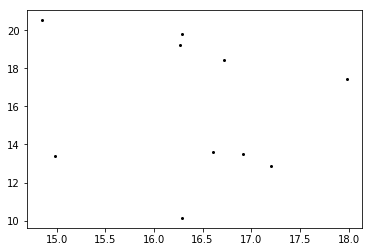

In [112]:
keplerMag = match[0]['MAG_BEST']
gaiaMag = match[1]['phot_g_mean_mag']
plt.plot(keplerMag[0:10],gaiaMag[0:10],'ko',markersize=2)
plt.show()

In [110]:
match[0][0:10]

NUMBER,FLUX_BEST,FLUXERR_BEST,MAG_BEST,X_IMAGE,Y_IMAGE,ELLIPTICITY,RA,DEC,IMAGE_NAME,MEDIAN_NAME,DIFF_NAME,index
int64,float64,float64,float64,float64,float64,float64,float64,float64,str34,str18,str32,int64
7,11456.36,280.9146,14.8524,574.5563,1008.829,0.434,290.154244155043,40.93553403531398,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,6
10,2277.93,34.05597,16.6061,429.0159,992.2977,0.058,290.3189672067992,41.03903357582664,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,9
16,3054.787,57.26656,16.2875,431.1161,902.2485,0.255,290.24398542974404,41.12090268582241,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,15
20,3052.171,35.77414,16.2885,1067.9397,878.5374,0.074,289.44881212003037,40.75399198948763,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,19
25,643.2305,26.07466,17.9791,906.3129,742.7368,0.252,289.5346598957401,40.97787958211275,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,24
37,2050.519,31.83027,16.7203,757.8644,625.5156,0.049,289.62014431369175,41.176573052631966,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,36
51,1316.578,21.60069,17.2014,846.3585,411.3842,0.136,289.3370440227031,41.31871402777068,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,50
59,3098.985,36.51183,16.272,521.098,316.912,0.171,289.6580544878012,41.605185276102596,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,58
61,10156.0,43.35539,14.9832,761.9088,241.4618,0.003,289.3006230731252,41.52648056165964,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,60


In [111]:
match[1][0:10]

dist,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,index
float64,int64,str28,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,int64,str5,float64,float64,float64,float64,int64,int64,float64,int64,int64,str5,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,str13,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,str77,str99,int64
0.0004856895386947052,1635721458409799680,Gaia DR2 2101397003944879744,2101397003944879744,1460115014,2015.5,290.1541864197112,0.5432112779766552,40.9350567951846,0.7683634845762366,-1.3875383085515758,0.6925544086393817,-2.003508,-1.6469723906519274,1.1554458124932419,0.02832046423850106,1.7692631528420302,0.08079609,0.26672313,0.08902849,-0.30213055,0.26576456,-0.3175182,-0.115155965,-0.06868647,0.057202842,0.013251644,167,0,167,0,1.933488,198.58994,1.4973966196441795,0.7626853853394648,31,False,0.037213326,1.7492072531715066,0.1656579173208149,0.21154217,20,14,1.5636353,0,22,False,185,115.98480231678155,0.9944445855181093,116.632744,20.527363,14,96.61784003532408,15.769214245003758,6.1269913,20.388744,15,109.9780189881386,9.456519384464732,11.629863,19.658655,1.7812321,0,0.7300892,-0.13861847,0.86870766,0.0,0.0,0,0.0,0.0,0.0,NOT_AVAILABLE,72.8462236301454,12.321236533507404,303.7161711816616,62.03556137263401,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,http://geadata.esac.esa.int/data-server/datalink/links?ID=2101397003944879744,--,0
0.0004220522502123424,1635721458409799680,Gaia DR2 2101399306052024832,2101399306052024832,760687150,2015.5,290.3191674090691,0.01146370356861856,41.038643828467215,0.013157286534784192,2.6444742383694697,0.014254419301190787,185.5196,-5.097038692635611,0.02495669795514842,-0.9655807078618102,0.02803366587614792,0.030564,0.00073369377,-0.053977344,-0.042234153,0.19177416,-0.077061795,-0.1397227,-0.18708868,-0.16435198,0.062010564,235,0,233,2,-4.561351,143.31865,0.0,0.0,31,True,91.91692,1.5463240794613022,0.0035608379413206246,0.09213